## Import the model and weights


In [1]:
from modeling.titok import *
from omegaconf import OmegaConf 
config = OmegaConf.load("configs/training/stage1/titok_l32_CSL.yaml")
model = TiTok(config)
weights = "titok_l_32_stage1_run1/checkpoint-Titok/pytorch_model.bin"

# load the weights 
model.load_state_dict(torch.load(weights))

attention mode is flash


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

### Checking validation images

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S003469_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S003469_P0000_T00\000009.jpg
orginal image: torch.Size([3, 256, 256])


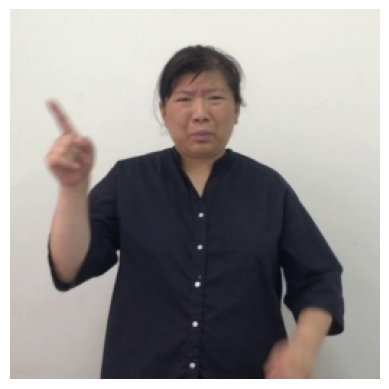

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


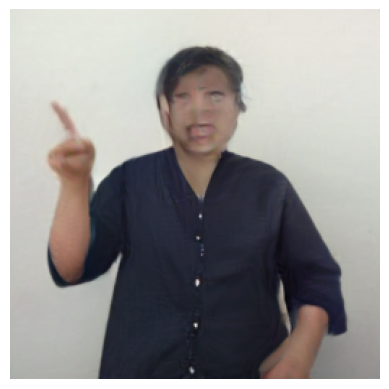

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S007160_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S007160_P0000_T00\000041.jpg
orginal image: torch.Size([3, 256, 256])


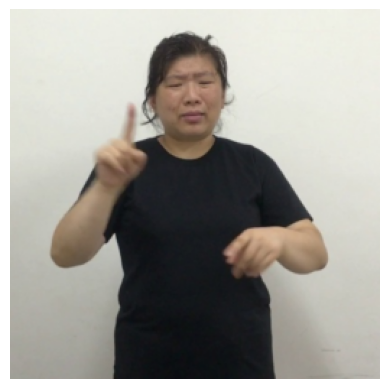

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


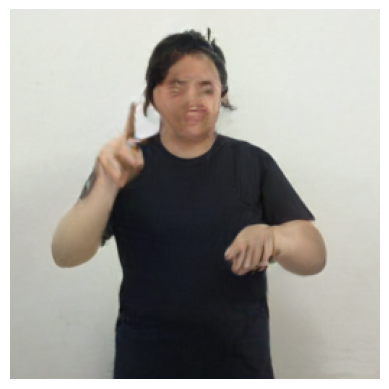

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S001517_P0008_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S001517_P0008_T00\000038.jpg
orginal image: torch.Size([3, 256, 256])


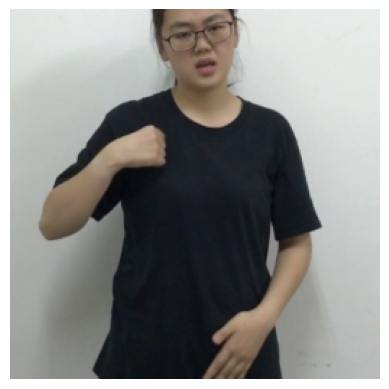

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


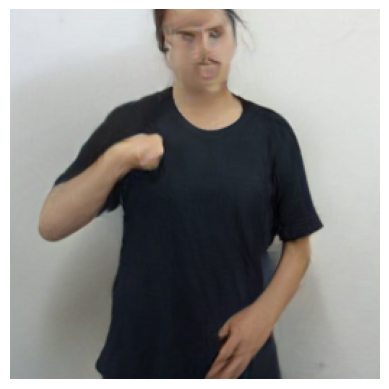

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S002580_P0005_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S002580_P0005_T00\000066.jpg
orginal image: torch.Size([3, 256, 256])


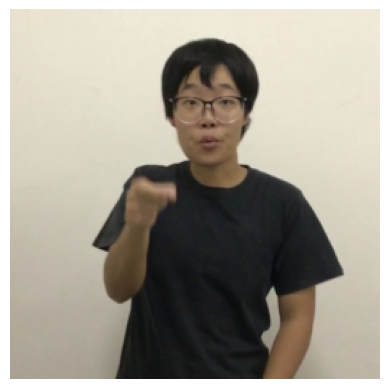

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


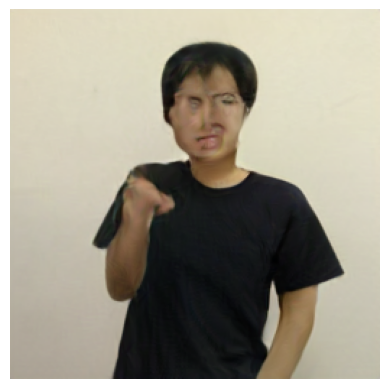

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000034.jpg
orginal image: torch.Size([3, 256, 256])


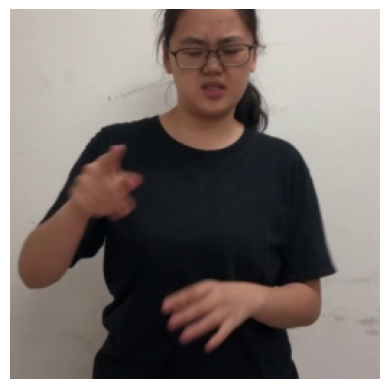

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


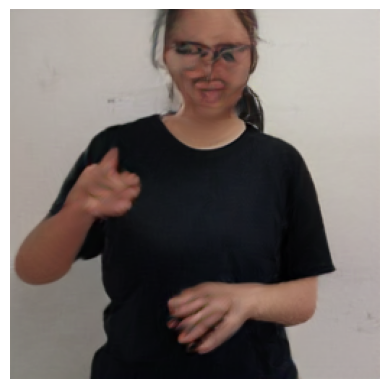

In [4]:
import os
import random
from PIL import Image
import numpy as np 
from torchvision import transforms
from IPython.display import display 
import matplotlib.pyplot as plt


maskgit =  PretrainedTokenizer(config.model.vq_model.pretrained_tokenizer_weight).to("cuda")
def tokenize_and_reconstruct(model, img_path=None, encoded_tokens=None):
    # Preprocess the image  
    image = Image.open(img_path).convert("RGB")
    person_size = 410
    # Calculate the center horizontal crop and lower vertical crop
    x_start = int((image.size[0] - person_size) // 2)  # Center horizontally
    x_end = x_start + person_size
    y_start = image.size[1] - person_size # Crop the lower vertical section
    y_end = image.size[1]

    # Crop the image (keeping center horizontal and lower vertical)
    image = image.crop((x_start, y_start, x_end, y_end))
    # add transforms 
    # Normalization values for ImageNet
    norm_mean = [0,0,0]
    norm_std = [1,1,1]
    # Data transformations for validation and test sets (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to fixed size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(norm_mean, norm_std)  # Normalize using ImageNet statistics
    ])

    image = eval_transform(image)
    print(f"orginal image: {image.shape}")
    # Plot the image
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.axis('off')  # Remove axis
    plt.show()
    model = model.to("cuda")

    image = torch.from_numpy(np.array(image).astype(np.float32)).unsqueeze(0)
    if analyse_tensor== False: 
        encoded_tokens = model.encode(image.to("cuda"))[1]["min_encoding_indices"]
    print(f"encoded tokens: {encoded_tokens.shape}")
    reconstructed_image = model.decode_tokens(encoded_tokens)
    reconstructed_image = maskgit.decode(reconstructed_image.argmax(1))
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).to("cpu", dtype=torch.uint8).numpy()[0].transpose(1, 2, 0)
    #reconstructed_image = Image.fromarray(reconstructed_image.transpose(1, 2, 0))
    #print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    
    print(f"reconstructed image: {reconstructed_image.shape}")
    # Plot the image
    plt.imshow(reconstructed_image  )
    plt.axis('off')  # Remove axis
    plt.show()

img_path = config.dataset.params.img_path + "/dev"
# Get a list of all folders in the image path
folders = [os.path.join(img_path, folder) for folder in os.listdir(img_path) if os.path.isdir(os.path.join(img_path, folder))]

for i in range(5): 
    # Select a random folder
    random_folder = random.choice(folders)
    print(f"random folder: {random_folder}")
    # Get a list of all images in the selected folder
    analyse_tensor = False
    if analyse_tensor : 
        encoded_tokens = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.pt'))]
        random_token = random.choice(encoded_tokens)
        print(f"random token file: {random_token}")
        random_token = torch.load(random_token).unsqueeze(0).unsqueeze(0).cuda()
        print(f"encoded tokens: {random_token}")
    else: 
        images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Select a random image
    random_image_path = random.choice(images)
    print(f"random image: {random_image_path}")




    # Get the reconstuction + Display the reconstructed image
    tokenize_and_reconstruct(model=model, img_path=random_image_path, encoded_tokens=None)

### Testing decoding from 32 Tokens

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S004936_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000077.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000077.pt
encoded tokens: tensor([[[ 145, 2534, 2919,  420, 1547,  957, 2070, 2685,  349, 2169, 3946,
          3804, 1311, 3857, 2605, 4094, 1823, 3171,  673, 3318, 1396,  662,
           248, 1146,  858,  445, 2122, 1538, 2924, 3011, 3586, 2386]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


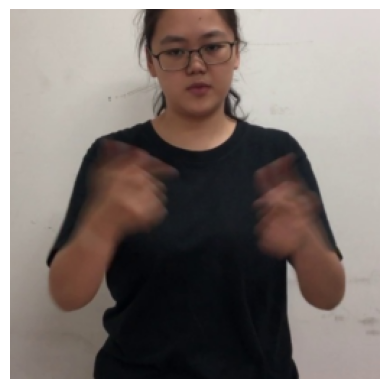

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


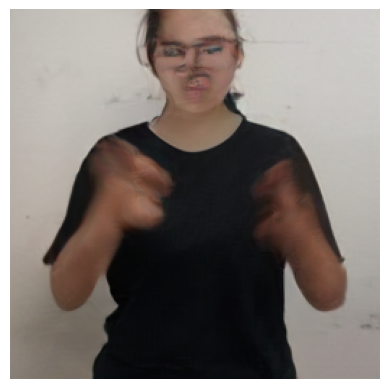

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S003289_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000042.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000042.pt
encoded tokens: tensor([[[ 973, 3759, 1922,  828, 3825, 2887, 1146, 3525, 3279, 1868, 1336,
           191, 1311,  151, 1763,  699, 1148, 1933,  835, 1067, 3800,  920,
          2336, 2754, 3168, 2049, 3557, 2827, 1981, 2746,  869, 3332]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


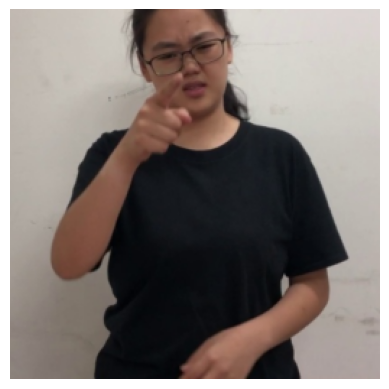

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


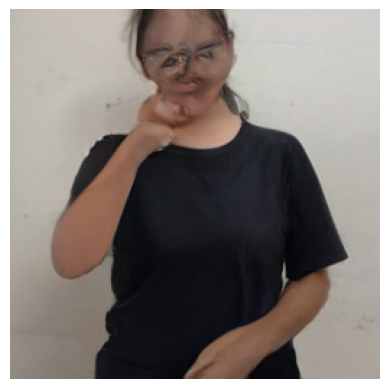

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S007256_P0007_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000085.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000085.pt
encoded tokens: tensor([[[3923,  508, 2588,  436, 2565, 2141, 1822, 3411, 3438,  363, 3956,
          3245, 1311, 3148, 1042, 2523, 3119, 2377, 3254, 3473, 1324,  802,
          2412, 3768, 3587,  284,  432, 4043, 1978, 1862, 3152, 2189]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


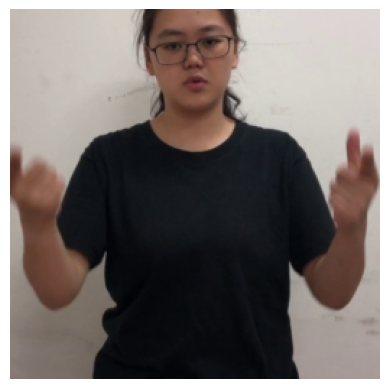

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


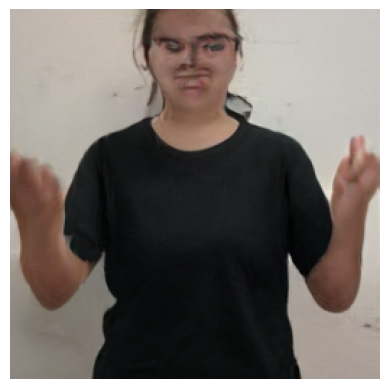

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S001841_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000011.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000011.pt
encoded tokens: tensor([[[1790,  687, 1290,  311,  641, 2507, 2146, 2460, 3052, 3081, 1173,
          1087, 1091, 1175,   86, 2040, 1438, 4003, 3178, 1882, 2205, 3005,
          3483, 3750, 2774, 3585,  248,  365, 3106, 3598, 3781, 2189]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


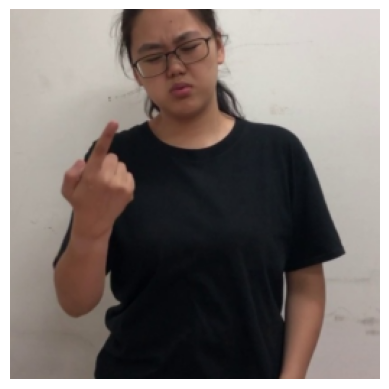

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


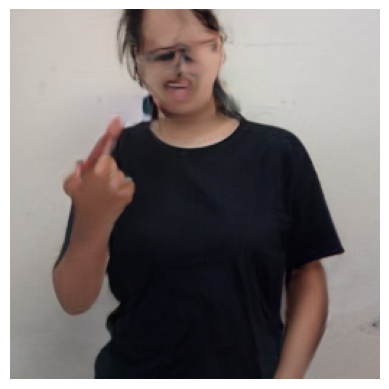

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S001900_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000076.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S004386_P0008_T00\000076.pt
encoded tokens: tensor([[[ 262, 3465, 3597,  644, 2739,  611,  319, 2836, 1999, 2169,  520,
          3804, 1311, 1249,  821, 3420, 2386, 2844,  197, 2524, 1709, 2377,
           248, 1998, 3278, 2013, 3239, 3552, 1939, 3602, 3613, 2869]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


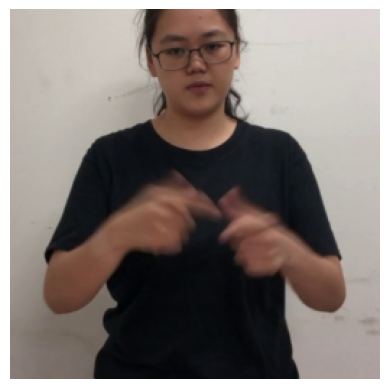

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


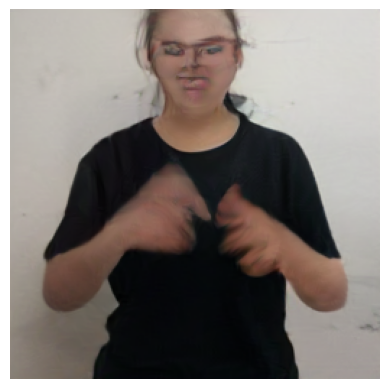

In [6]:

for i in range(5): 
    # Select a random folder
    random_folder = random.choice(folders)
    print(f"random folder: {random_folder}")
    # Get a list of all images in the selected folder
    analyse_tensor = True 
    random_image_path = random.choice(images)
    print(f"random image: {random_image_path}")
    if analyse_tensor : 
        random_token = os.path.splitext(random_image_path)[0] + ".pt"
        print(f"random token file: {random_token}")
        random_token = torch.load(random_token).unsqueeze(0).unsqueeze(0).cuda()
        print(f"encoded tokens: {random_token}")
    else: 
        images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Select a random image
    




    # Get the reconstuction + Display the reconstructed image
    tokenize_and_reconstruct(model=model, img_path=random_image_path, encoded_tokens=random_token)